In [76]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
plt.style.use('~/line_plot.mplstyle')
import json, os, pickle
from scipy.signal import argrelmin
from pathlib import Path

C6 = 2 * np.pi * .862690

In [77]:
def lieb_lattice(n_x, n_y, a, y_periodic=False, bc_boundary=False):
    # n_x and n_y are unit cells of the Lieb lattice, not rows and columns
    atoms = []
    unit_cell_inds = []

    site_ind = 0

    a_inds = []
    b_inds = []
    c_inds = []

    def add_a_site(x, y):
        nonlocal site_ind
        atoms.append([a * 2 * x, a * 2 * y])
        a_inds.append(site_ind)
        site_ind += 1

    def add_b_site(x, y):
        nonlocal site_ind
        atoms.append([a * (2 * x + 1), a * 2 * y])
        b_inds.append(site_ind)
        site_ind += 1

    def add_c_site(x, y):
        nonlocal site_ind
        atoms.append([a * 2 * x, a * (2 * y + 1)])
        c_inds.append(site_ind)
        site_ind += 1
    

    for x in range(n_x):
        for y in range(n_y):
            unit_cell_inds.append([site_ind, site_ind + 1, site_ind + 2])

            add_a_site(x, y)
            add_b_site(x, y)
            add_c_site(x, y)


            if bc_boundary:
                if x == 0:
                    add_b_site(x - 1, y)
                
                if y == 0 and not y_periodic:
                    add_c_site(x, y - 1)
            else:
                if x == n_x - 1:
                    add_a_site(x + 1, y)
                    add_c_site(x + 1, y)

                if y == n_y - 1 and not y_periodic:
                    add_a_site(x, y + 1)
                    add_b_site(x, y + 1)

    if not bc_boundary and not y_periodic:
        add_a_site(n_x, n_y)
             
    sublattice_inds = [a_inds, b_inds, c_inds]

    return atoms, sublattice_inds, unit_cell_inds

# def generate_sites_lieb_lattice(n_x, n_y, include_last_column=True):
#     # n_x and n_y are unit cells of the Lieb lattice, not rows and columns
#     sites = []

#     x_ind = 0
#     y_ind = 0

#     for ii in range(n_x):
#         x_ind += 1

#         for jj in range(n_y):
#             y_ind += 1
#             sites.append([x_ind, y_ind])
#             y_ind += 1
#             sites.append([x_ind, y_ind])

#         x_ind += 1
#         y_ind -= 1

#         for jj in range(n_y):
#             sites.append([x_ind, y_ind])
#             y_ind -= 2

#         y_ind += 1

#     if include_last_column:
#         x_ind += 1

#         for jj in range(n_y):
#             y_ind += 1
#             sites.append([x_ind, y_ind])
#             y_ind += 1
#             sites.append([x_ind, y_ind])

#     return sites

# def generate_bc_sites_lieb_lattice(n_x, n_y, include_last_column=True):
#     # n_x and n_y are unit cells of the Lieb lattice, not rows and columns
#     sites = []

#     x_ind = 0
#     y_ind = 0

#     for ii in range(n_x):
#         x_ind += 1

#         for jj in range(n_y):
#             y_ind += 1
#             # sites.append([x_ind, y_ind])
#             y_ind += 1
#             sites.append([x_ind, y_ind])

#         x_ind += 1
#         y_ind -= 1

#         for jj in range(n_y):
#             sites.append([x_ind, y_ind])
#             y_ind -= 2

#         y_ind += 1

#     if include_last_column:
#         x_ind += 1

#         for jj in range(n_y):
#             y_ind += 1
#             # sites.append([x_ind, y_ind])
#             y_ind += 1
#             sites.append([x_ind, y_ind])

#     return sites

def manual_ft(density, sites, k):
    N = len(density)
    
    x = np.array(sites)[:, 0]
    y = np.array(sites)[:, 1]
    
    phase_1 = np.exp(1j * k[0] * x)
    phase_2 = np.exp(1j * k[1] * y)
    
    return np.sum(np.multiply(phase_1, np.multiply(phase_2, density))) / np.sqrt(N)

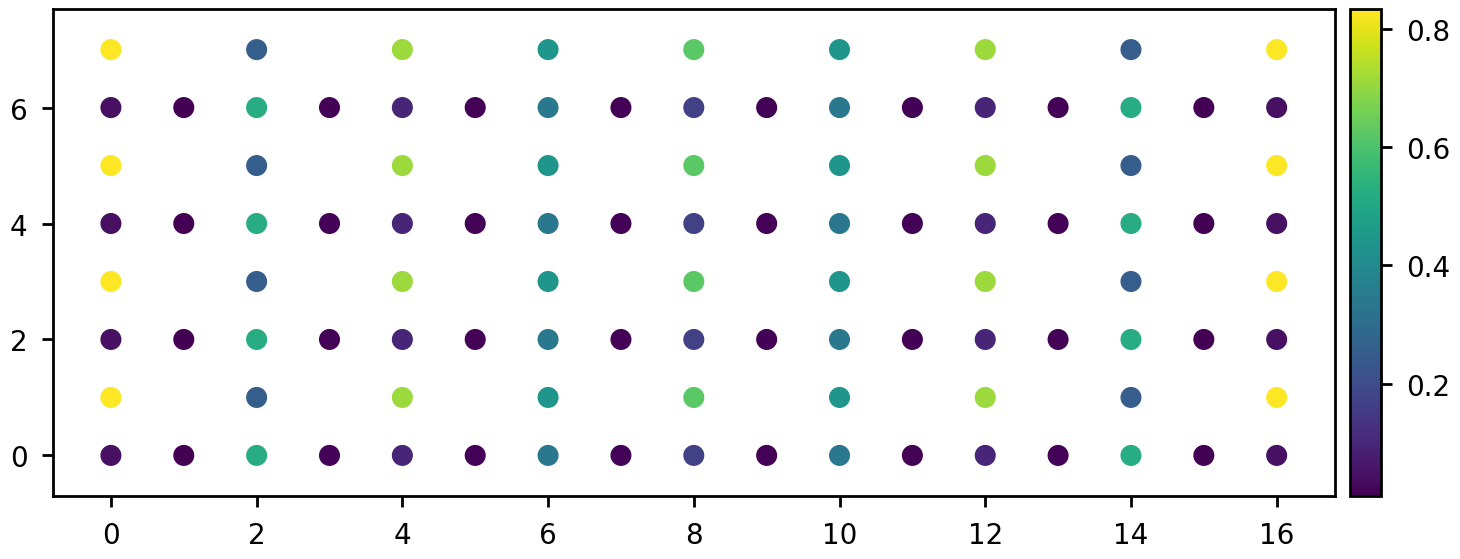

In [64]:
# f_name = "/global/homes/m/mhirsbru/Rydberg-Array-DMRG/data/lieb/archive/trial_1/phase_diagram_data/1.8_3.5_0.json"
# f_name = "/global/homes/m/mhirsbru/Rydberg-Array-DMRG/data/lieb/fss_colinear_2/phase_diagram_data/3_1.5_1.2_0.json"
# f_name = "/global/homes/m/mhirsbru/Rydberg-Array-DMRG/data/lieb/local_detuning_19x10/phase_diagram_data/1.2_1.4_0.39.json"

f_name = "/global/homes/m/mhirsbru/Rydberg-Array-DMRG/data/lieb/8x4_cylinder_pd/phase_diagram_data/1.6_2.0_0.json"


with open(f_name, "rb") as io:
    data_dict = json.load(io)
    
n_x = data_dict["params"]["ham_config"]["n_x"]
n_y = data_dict["params"]["ham_config"]["n_y"]
delta = data_dict["params"]["ham_config"]["delta"]
delta_local = data_dict["params"]["ham_config"]["delta_local"]

density = np.array(data_dict["results"]["rydberg_density"])

# sites = generate_sites_lieb_lattice(n_x, n_y)
sites, sublattice_inds, unit_cell_inds = lieb_lattice(n_x, n_y, 1, True, data_dict["params"]["ham_config"]["bc_boundary"])
# sites, sublattice_inds, unit_cell_inds = lieb_lattice(n_x, n_y, 1)

# bc_sites = generate_bc_sites_lieb_lattice(n_x, n_y)
bc_sites = [sites[x] for x in sublattice_inds[1]] + [sites[x] for x in sublattice_inds[2]]

xs = [site[0] for site in sites]
ys = [site[1] for site in sites]

bc_xs = [site[0] for site in bc_sites]
bc_ys = [site[1] for site in bc_sites]
    
aspect = 20
pad_fraction = 0.5

scale = 1.5
fig, ax = plt.subplots(figsize=(scale * (n_x + 2), scale * n_y))

im = ax.scatter(xs, ys, s=200, c=density)
# im = ax.scatter(xs, ys, s=200, c='k')

ax.set_xmargin(0.05)
ax.set_ymargin(0.1)

divider = make_axes_locatable(ax)
width = axes_size.AxesY(ax, aspect=1./aspect)
pad = axes_size.Fraction(pad_fraction, width)
cax = divider.append_axes("right", size=width, pad=pad)
plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

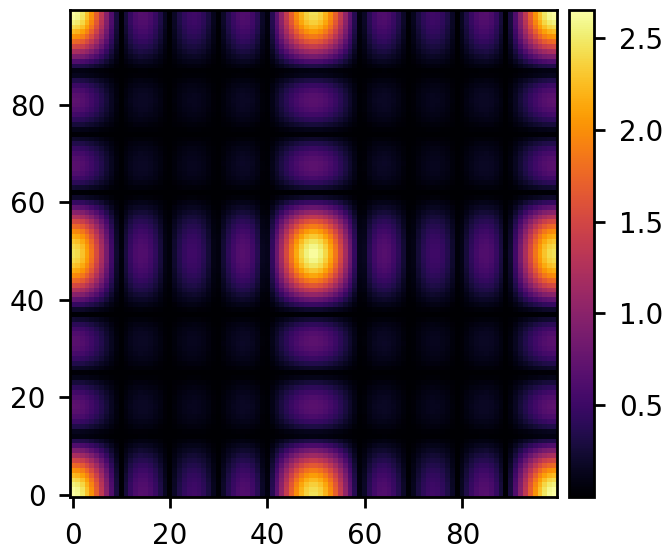

In [4]:
k_pts = 100
k_ax = np.linspace(0, 2 * np.pi, k_pts)

ft = np.zeros((k_pts, k_pts), dtype=complex)

for ii in range(k_pts):
    for jj in range(k_pts):
        ft[ii, jj] = manual_ft(density, sites, [k_ax[ii], k_ax[jj]])
        
aspect = 20
pad_fraction = 0.5

fig, ax = plt.subplots(figsize=(12, 6))

im = ax.imshow(np.abs(ft).T, cmap='inferno', origin="lower")

divider = make_axes_locatable(ax)
width = axes_size.AxesY(ax, aspect=1./aspect)
pad = axes_size.Fraction(pad_fraction, width)
cax = divider.append_axes("right", size=width, pad=pad)
plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

In [54]:
print(sorted(list(set(rbs))))

[1.2, 1.225, 1.25, 1.275, 1.3, 1.325, 1.35, 1.375, 1.4, 1.425, 1.45, 1.475, 1.5, 1.525, 1.55, 1.575, 1.6, 1.625, 1.65, 1.675, 1.7, 1.725, 1.75, 1.775, 1.8, 1.825, 1.85, 1.875, 1.9, 1.925, 1.95, 1.975, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4]


In [5]:
### Plot the phase diagram

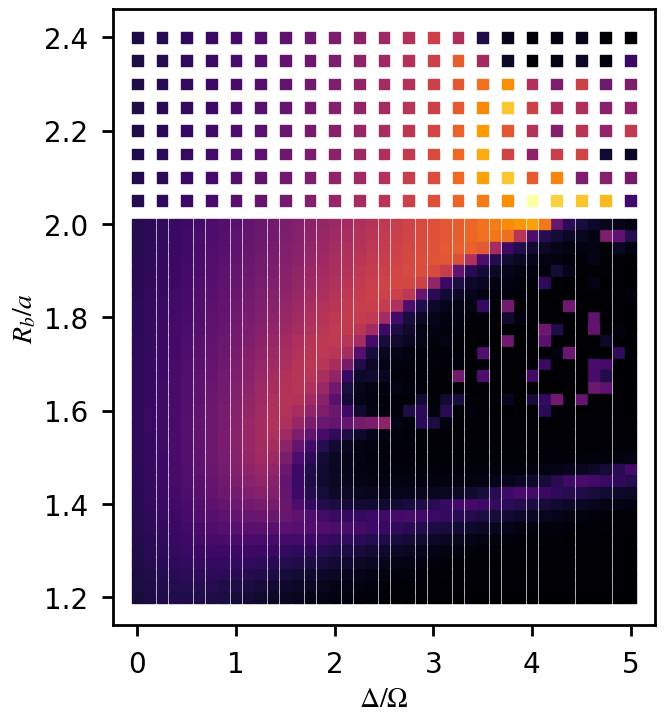

In [79]:
# data_dir = "/global/homes/m/mhirsbru/Rydberg-Array-DMRG/data/lieb/archive/trial_1/phase_diagram_data"
# data_dir = "/global/homes/m/mhirsbru/Rydberg-Array-DMRG/data/lieb/abc_boundary_obc/phase_diagram_data/"
data_dir = "/global/homes/m/mhirsbru/Rydberg-Array-DMRG/data/lieb/8x4_cylinder_pd/phase_diagram_data"


f_names = os.listdir(data_dir)

rbs = []
deltas = []
ent_entropies = []

for f_name in f_names:

  with open(Path(data_dir, f_name), 'r') as f:
    data_dict = json.load(f)

  rbs.append(data_dict["params"]["ham_config"]["Rb"])
  deltas.append(data_dict["params"]["ham_config"]["delta"])
  ent_entropies.append(data_dict["results"]["entanglement_entropy"])

n_rb = len(set(rbs))
n_delta = len(set(deltas))

rbs = np.array(rbs)
deltas = np.array(deltas)
ent_entropies = np.array(ent_entropies)

###

# rb_inds = rbs.argsort()

# rbs = rbs[rb_inds[::-1]]
# deltas = deltas[rb_inds[::-1]]
# ent_entropies = ent_entropies[rb_inds[::-1]]

# rbs = np.reshape(rbs, (n_rb, n_delta))
# deltas = np.reshape(deltas, (n_rb, n_delta))
# ent_entropies = np.reshape(ent_entropies, (n_rb, n_delta))

# for ii in range(n_rb):
#     delta_inds = deltas[ii].argsort()
    
#     rbs[ii] = rbs[ii][delta_inds[::1]]
#     deltas[ii] = deltas[ii][delta_inds[::1]]
#     ent_entropies[ii] = ent_entropies[ii][delta_inds[::1]]

# fig, ax = plt.subplots(figsize=(6, 5))

# ax.imshow(ent_entropies, cmap="magma", origin='upper', aspect='auto', extent=(np.min(deltas), np.max(deltas), np.min(rbs), np.max(rbs)))

###

fig, ax = plt.subplots(figsize=(7, 8))

ax.scatter(deltas, rbs, s=60, c=ent_entropies, cmap='inferno', marker='s', vmin=0)
ax.margins(0.05)

###

ax.set_yticks((1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4))

ax.set_xlabel(r'$\Delta/\Omega$')
ax.set_ylabel(r'$R_b/a$')

plt.show()

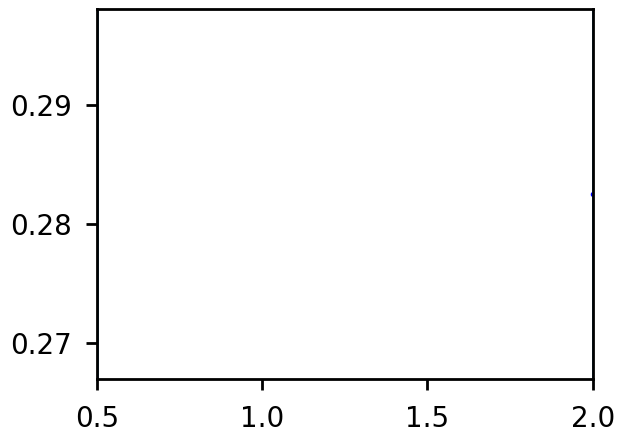

In [7]:
ind = -41
plt.plot(deltas[ind], ent_entropies[ind], 'b.')
plt.axvline(0.5)
plt.axvline(2.0)
plt.show()

In [8]:
def bc_mag(n_x, n_y, density):
    sites = generate_sites_lieb_lattice(n_x, n_y)
    bc_sites = generate_bc_sites_lieb_lattice(n_x, n_y)
    
    bc_site_inds = []

    for ii in range(len(sites)):
        if sites[ii] in bc_sites:
            bc_site_inds.append(ii)
    
    op = 0
    
    for ind in bc_site_inds:
        op += density[ind]
        
    return op / (3 * len(sites))

In [9]:
data_dir = "/global/homes/m/mhirsbru/Rydberg-Array-DMRG/data/lieb/local_detuning_19x10/phase_diagram_data"

f_names = os.listdir(data_dir)

deltas = []
delta_locals = []
ops = []
ent_entropies = []

for f_name in f_names:

    with open(Path(data_dir, f_name), 'r') as f:
        data_dict = json.load(f)

    n_x = data_dict["params"]["ham_config"]["n_x"]
    n_y = data_dict["params"]["ham_config"]["n_y"]
    
    deltas.append(data_dict["params"]["ham_config"]["delta"])
    delta_locals.append(data_dict["params"]["ham_config"]["delta_local"])
    
    ops.append(bc_mag(n_x, n_y, data_dict["results"]["rydberg_density"]))
    ent_entropies.append(data_dict["results"]["entanglement_entropy"])

rb = data_dict["params"]["ham_config"]["Rb"]
n_delta = len(set(deltas))
n_delta_local = len(set(delta_locals))

deltas = np.array(deltas)
delta_locals = np.array(delta_locals)
ops = np.array(ops)
ent_entropies = np.array(ent_entropies)

sites = generate_sites_lieb_lattice(n_x, n_y)
bc_sites = generate_bc_sites_lieb_lattice(n_x, n_y)


NameError: name 'generate_sites_lieb_lattice' is not defined

In [ ]:
delta_inds = deltas.argsort()

deltas = deltas[delta_inds[::1]]
delta_locals = delta_locals[delta_inds[::1]]
ops = ops[delta_inds[::1]]
ent_entropies = ent_entropies[delta_inds[::1]]

deltas = np.reshape(deltas, (n_delta, n_delta_local))
delta_locals = np.reshape(delta_locals, (n_delta, n_delta_local))
ops = np.reshape(ops, (n_delta, n_delta_local))
ent_entropies = np.reshape(ent_entropies, (n_delta, n_delta_local))

for ii in range(n_delta):
    delta_local_inds = delta_locals[ii].argsort()

    deltas[ii] = deltas[ii][delta_local_inds[::1]]
    delta_locals[ii] = delta_locals[ii][delta_local_inds[::1]]
    ops[ii] = ops[ii][delta_local_inds[::1]]
    ent_entropies[ii] = ent_entropies[ii][delta_local_inds[::1]]

###

fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(ent_entropies.T, cmap="viridis", origin='upper', aspect='auto', extent=(np.min(deltas), np.max(deltas), np.max(delta_locals), np.min(delta_locals)))
fig.colorbar(im)

ax.set_xlabel(r'$\Delta/\Omega$')
ax.set_ylabel(r'$\Delta_L/\Omega$')

plt.tight_layout()

plt.show()

###

fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(ops.T, cmap="bwr", origin='upper', aspect='auto', extent=(np.min(deltas), np.max(deltas), np.max(delta_locals), np.min(delta_locals)))
fig.colorbar(im)

ax.set_xlabel(r'$\Delta/\Omega$')
ax.set_ylabel(r'$\Delta_L/\Omega$')

plt.tight_layout()

plt.show()

In [ ]:

for ind in range(1, 15):
    plt.plot(deltas[:, -ind], ops[:, -ind], '.')
    # plt.title(f"Delta_local = {delta_locals[0, ind]:.3f}")
    plt.margins(0.05)

plt.tight_layout()
plt.show()

In [ ]:
temp_delta_locals = []
bc_op_jumps = []

for ii in range(delta_locals.shape[-1]):
    temp_delta_locals.append(delta_locals[0, ii])
    bc_op_jumps.append(np.max(np.abs(np.diff(ops[:, ii]))))
    
op_jump_results = {"delta_locals" : temp_delta_locals, "op_jumps" : bc_op_jumps}

with open('op_jump_data.pickle', 'wb') as handle:
    pickle.dump(op_jump_results, handle)

In [ ]:
plt.plot(delta_locals[0, :], bc_op_jumps)